In [1]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install huggingface-hub
!pip install joblib
!pip install librosa
!pip install pyctcdecode
!pip install tokenizers

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-qbtn62sw
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-qbtn62sw
  Resolved https://github.com/huggingface/transformers.git to commit 52cb4034ada381fe1ffe8d428a1076e5411a8026
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.45.0.dev0-py3-none-any.whl size=9530618 sha256=c698e4ea6f177b0f96a04aa20466117d5db8925b9c8c221c60cf053b863ddfe2
  Stored in directory: /tmp/pip-ephem-wheel-cache-xlgv8d5w/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 18 12:09:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
  print('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

Tensorflow version 2.17.0
ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!


In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## RAVDESS
Link: https://zenodo.org/records/1188976#.YFZuJ0j7SL8

Filename identifiers

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [5]:
import pandas as pd
import numpy as np

import os
import zipfile

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, GlobalAveragePooling1D, Layer, TimeDistributed
from keras.callbacks import ModelCheckpoint

Ravdess = 'ravdess/RAVDESS/Audio_Speech_Actors_01-24/'
Crema = 'crema/CREMA/'
Tess = 'tess/TESS/'

In [6]:
from google.colab import drive
drive.mount('/content/drive')
HOME_DIR = '/content/drive/MyDrive/ML3_FP/'

Mounted at /content/drive


In [7]:
def extract_zip(zip_file_path, extraction_path):
  # Create the extraction directory if it doesn't exist
  os.makedirs(extraction_path, exist_ok=True)

  # Check if the file exists
  if not os.path.exists(zip_file_path):
      print(f"Error: File not found at '{zip_file_path}'")
  else:
      # Check if the file is a valid zip file
      if zipfile.is_zipfile(zip_file_path):
          # Create the extraction directory if it doesn't exist
          os.makedirs(extraction_path, exist_ok=True)

          # Unzip the file
          with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
              zip_ref.extractall(extraction_path)

          print(f'Files have been extracted to {extraction_path}')
      else:
          print(f"Error: The file '{zip_file_path}' is not a valid zip file.")

In [8]:
ravdess_extraction_path = 'ravdess'
tess_extraction_path = 'tess'
crema_extraction_path = 'crema'

In [9]:
extract_zip(HOME_DIR + 'data/RAVDESS.zip', 'ravdess')
extract_zip(HOME_DIR + 'data/TESS.zip', 'tess')
extract_zip(HOME_DIR + 'data/CREMA.zip', 'crema')

Files have been extracted to ravdess
Files have been extracted to tess
Files have been extracted to crema


In [10]:
ravdess_directory_list = os.listdir(ravdess_extraction_path + '/RAVDESS/Audio_Speech_Actors_01-24')
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    if os.path.isdir(Ravdess + dir):
        actor = os.listdir(Ravdess + dir)
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            # third part in each file represents the emotion associated to that file.
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({
    1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'
}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,fear,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...
1,calm,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...
2,surprise,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...
3,neutral,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...
4,disgust,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...


## TESS

https://tspace.library.utoronto.ca/handle/1807/24487

In [11]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for file in tess_directory_list:
    if ".wav" in file:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,disgust,tess/TESS//OAF_kill_disgust.wav
1,sad,tess/TESS//YAF_hall_sad.wav
2,happy,tess/TESS//YAF_keep_happy.wav
3,surprise,tess/TESS//YAF_deep_ps.wav
4,angry,tess/TESS//YAF_pick_angry.wav


## CREMA

In [12]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,happy,crema/CREMA/1014_IOM_HAP_XX.wav
1,fear,crema/CREMA/1035_TAI_FEA_XX.wav
2,angry,crema/CREMA/1003_ITS_ANG_XX.wav
3,sad,crema/CREMA/1018_DFA_SAD_XX.wav
4,neutral,crema/CREMA/1040_IWW_NEU_XX.wav


## Join all files

In [13]:
# remove calm and surprise emotion because there are too little occurrences
crema_df = Crema_df[Crema_df.Emotions!='calm']
Ravdess_df = Ravdess_df[Ravdess_df.Emotions!='calm']
Tess_df = Tess_df[Tess_df.Emotions!='calm']

crema_df = Crema_df[Crema_df.Emotions!='surprise']
Ravdess_df = Ravdess_df[Ravdess_df.Emotions!='surprise']
Tess_df = Tess_df[Tess_df.Emotions!='surprise']

In [14]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv(HOME_DIR + "data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,fear,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...
3,neutral,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...
4,disgust,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...
6,neutral,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...
7,angry,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...


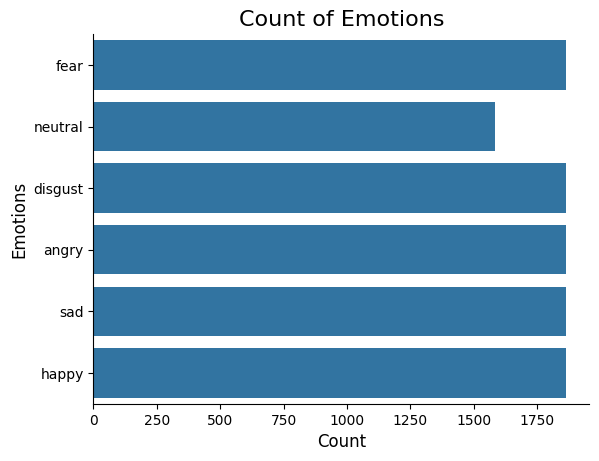

In [15]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Emotions', size=12)
plt.xlabel('Count', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [16]:
data_path.head(3)

,Emotions,Path
0,fear,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...
3,neutral,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...
4,disgust,ravdess/RAVDESS/Audio_Speech_Actors_01-24/Acto...


In [17]:
raw_data = []
for ind, row in data_path.iterrows():
  temp = {}
  audio = librosa.load(row['Path'], sr=16000)
  temp['audio'] = audio[0]
  temp['label'] = row['Emotions']
  raw_data.append(temp)

raw_df = pd.DataFrame(raw_data)
raw_df

,audio,label
0,"[-5.684342e-14, 0.0, 2.2737368e-13, 1.1368684e...",fear
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",neutral
2,"[8.920978e-09, -1.2499697e-08, 1.6353084e-08, ...",disgust
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",neutral
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",angry
...,...,...
10893,"[-1.4286721e-05, -5.9815808e-05, -0.0001333495...",fear
10894,"[0.00022654486, -0.00033948128, -0.00048271797...",disgust
10895,"[5.910406e-07, -0.00016631535, -0.00011454604,...",angry
10896,"[-2.4111941e-05, -0.00011284882, -6.082689e-05...",angry


In [18]:
# Maximum duration of the input audio file we feed to our Wav2Vec 2.0 model.
MAX_DURATION = 3
# Sampling rate is the number of samples of audio recorded every second
SAMPLING_RATE = 16000
BATCH_SIZE = 8  # Batch-size for training and evaluating our model.
NUM_CLASSES = 6  # Number of classes our dataset.
HIDDEN_DIM = 768  # Dimension of our model output (768 in case of Wav2Vec 2.0 - Base).
MAX_SEQ_LENGTH = MAX_DURATION * SAMPLING_RATE  # Maximum length of the input audio file.
# Wav2Vec 2.0 results in an output frequency with a stride of about 20ms.
MAX_FRAMES = 263
MAX_EPOCHS = 2  # Maximum number of training epochs.

MODEL_CHECKPOINT = "r-f/wav2vec-english-speech-emotion-recognition"

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
raw_df['label'] = le.fit_transform(raw_df['label'])
raw_df

,audio,label
0,"[-5.684342e-14, 0.0, 2.2737368e-13, 1.1368684e...",2
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
2,"[8.920978e-09, -1.2499697e-08, 1.6353084e-08, ...",1
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...
10893,"[-1.4286721e-05, -5.9815808e-05, -0.0001333495...",2
10894,"[0.00022654486, -0.00033948128, -0.00048271797...",1
10895,"[5.910406e-07, -0.00016631535, -0.00011454604,...",0
10896,"[-2.4111941e-05, -0.00011284882, -6.082689e-05...",0


In [20]:
le.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [21]:
import requests

# URL to download the configuration file
config_url = "https://huggingface.co/r-f/wav2vec-english-speech-emotion-recognition/raw/main/config.json"

# Local path to save the configuration file
local_config_path = 'config.json'

# Download the configuration file
response = requests.get(config_url)

# Check if the request was successful
if response.status_code == 200:
    # Save the content to a local file
    with open(local_config_path, 'w') as file:
        file.write(response.text)
    print(f"Configuration file downloaded and saved to {local_config_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Configuration file downloaded and saved to config.json


In [22]:
# URL to download the preprocessor configuration file
preprocessor_config_url = "https://huggingface.co/r-f/wav2vec-english-speech-emotion-recognition/raw/main/preprocessor_config.json"

# Local path to save the preprocessor configuration file
local_preprocessor_config_path = 'preprocessor_config.json'

# Download the preprocessor configuration file
response = requests.get(preprocessor_config_url)

# Check if the request was successful
if response.status_code == 200:
    # Save the content to a local file
    with open(local_preprocessor_config_path, 'w') as file:
        file.write(response.text)
    print(f"Preprocessor configuration file downloaded and saved to {local_preprocessor_config_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Preprocessor configuration file downloaded and saved to preprocessor_config.json


In [23]:
# URL to download the model weights (pytorch_model.bin)
weights_url = "https://huggingface.co/r-f/wav2vec-english-speech-emotion-recognition/resolve/main/pytorch_model.bin"

# Local path to save the model weights
local_weights_path = 'model_weights.bin'

# Download the model weights
response = requests.get(weights_url)

# Check if the request was successful
if response.status_code == 200:
    # Save the content to a local file in binary mode
    with open(local_weights_path, 'wb') as file:
        file.write(response.content)
    print(f"Model weights downloaded and saved to {local_weights_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Model weights downloaded and saved to model_weights.bin


In [24]:

training_args_url = "https://huggingface.co/r-f/wav2vec-english-speech-emotion-recognition/blob/main/training_args.bin"

# Local path to save the model weights
local_training_args_path = 'training_args.bin'

# Download the model weights
response = requests.get(training_args_url)

# Check if the request was successful
if response.status_code == 200:
    # Save the content to a local file in binary mode
    with open(local_training_args_path, 'wb') as file:
        file.write(response.content)
    print(f"Training args downloaded and saved to {local_training_args_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Training args downloaded and saved to training_args.bin


In [25]:
from transformers import Wav2Vec2Config, Wav2Vec2Model
import torch.nn as nn
from huggingface_hub import PyTorchModelHubMixin

config = Wav2Vec2Config.from_pretrained(local_config_path)
class Wav2Vec2ForSpeechClassification(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config):
        super(Wav2Vec2ForSpeechClassification, self).__init__()
        self.wav2vec2 = Wav2Vec2Model(config)

        self.classifier = nn.ModuleDict({
            'dense': nn.Linear(config.hidden_size, config.hidden_size),
            'activation': nn.ReLU(),
            'dropout': nn.Dropout(config.final_dropout),
            'out_proj': nn.Linear(config.hidden_size, config.num_labels)
        })

    def forward(self, input_values):
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs.last_hidden_state

        x = self.classifier['dense'](hidden_states[:, 0, :])
        x = self.classifier['activation'](x)
        x = self.classifier['dropout'](x)
        logits = self.classifier['out_proj'](x)

        return logits

# Create the model with the loaded configuration
model = Wav2Vec2ForSpeechClassification(config=config)

print("Model initialized successfully.")

Model initialized successfully.


In [26]:
import torch

local_weights_path = 'model_weights.bin'

state_dict = torch.hub.load_state_dict_from_url(weights_url, map_location=torch.device('cpu'))

# Load the model's state dictionary from the local file
state_dict = torch.load(local_weights_path, map_location=torch.device('cpu'))

# Apply the weights to the model
model.load_state_dict(state_dict, strict=True)

print("Model weights loaded from local file successfully.")

Downloading: "https://huggingface.co/r-f/wav2vec-english-speech-emotion-recognition/resolve/main/pytorch_model.bin" to /root/.cache/torch/hub/checkpoints/pytorch_model.bin
100%|██████████| 1.18G/1.18G [00:06<00:00, 210MB/s]


Model weights loaded from local file successfully.


In [27]:
import json
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Processor

# Load the preprocessor configuration from the local file
with open(local_preprocessor_config_path, 'r') as file:
    preprocessor_config = json.load(file)

# Initialize the preprocessor using the loaded configuration
feature_extractor = Wav2Vec2FeatureExtractor(
    do_normalize=preprocessor_config["do_normalize"],
    feature_extractor_type=preprocessor_config["feature_extractor_type"],
    feature_size=preprocessor_config["feature_size"],
    padding_side=preprocessor_config["padding_side"],
    padding_value=preprocessor_config["padding_value"],
    processor_class_from_name=preprocessor_config["processor_class"],
    return_attention_mask=preprocessor_config["return_attention_mask"],
    sampling_rate=preprocessor_config["sampling_rate"]
)

print("Preprocessor initialized successfully.")

Preprocessor initialized successfully.


In [50]:
le.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [53]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# Define the id2label mapping
id2label = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "neutral",
    5: "sad"
}


def predict(model, feature_extractor, data, max_length, id2label):
    # Extract features
    inputs = feature_extractor(data, sampling_rate=16000, max_length=max_length, return_tensors='tf', padding=True, truncation=True)
    torch_inputs = torch.tensor(inputs['input_values'].numpy(), dtype=torch.float32)

    # Forward pass
    outputs = model(input_values=torch_inputs)

    # Extract logits from the output
    logits = outputs

    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=-1)

    # Get the predicted class index
    predicted_class_idx = torch.argmax(probabilities, dim=-1).item()
    #predicted_label = id2label[predicted_class_idx]
    predicted_label = predicted_class_idx

    return predicted_label

# Define the evaluation function
def evaluate_model_inference(model, feature_extractor, dataset, max_length, id2label, df, is_print=False):
    correct_predictions = 0
    total_predictions = len(dataset)

    true_labels = []
    predicted_labels = []

    for i in tqdm(range(total_predictions), desc="Evaluating"):
        predicted_label = predict(model, feature_extractor, dataset[i], max_length, id2label)

        # Get actual label from the dataset
        actual_label = raw_df.iloc[i]['label']

        true_labels.append(actual_label)
        predicted_labels.append(predicted_label)

        # Check if prediction is correct
        if predicted_label == actual_label:
            correct_predictions += 1

        # Print prediction and actual label (optional)
        if is_print:
            print(f"Sample {i}: Predicted label: {predicted_label}, Actual label: {actual_label}")

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy, true_labels, predicted_labels

In [29]:
# Sample set to avoid crashing with T4 RAM (Doesn't crash on L4 pero mahal pag L4 eh HAHA)
#sample_df = raw_df.head(1000).copy()
sample_df = raw_df

In [30]:
# Pad the audio arrays to a uniform length
max_length = max(len(audio) for audio in sample_df["audio"])
padded_audio = [np.pad(audio, (0, max_length - len(audio))) for audio in sample_df["audio"]]
padded_audio_array = np.array(padded_audio)

In [31]:
# Define the range of indices
indices = np.arange(len(padded_audio_array))

# Define split ratios
train_ratio = 0.8
test_ratio = 0.2

# Shuffle the indices to ensure randomness
np.random.seed(42)  # For reproducibility (remove or change seed for different random results)
np.random.shuffle(indices)

# Calculate split points
total_size = len(indices)
train_size = int(total_size * train_ratio)
test_size = int(total_size * test_ratio)

# Split the indices
train_indices = indices[:train_size]
test_indices = indices[train_size:train_size + test_size]

# Print the indices to see the splits
print("Train indices:", train_indices)
print("Test indices:", test_indices)

# Get items for each set
train_data = padded_audio_array[train_indices]
test_data = padded_audio_array[test_indices]

labels = np.array(raw_df['label'])

train_labels = labels[train_indices]
test_labels = labels[test_indices]

print("Train data:", len(train_data))
print("Test data:", len(test_data))

print("Train labels:", len(train_labels))
print("Test labels:", len(test_labels))

Train indices: [10204 10786 10659 ...  5946  4583  5784]
Test indices: [7569  521 8714 ... 5191 5390  860]
Train data: 8718
Test data: 2179
Train labels: 8718
Test labels: 2179


In [32]:
# Evaluate the model (50 for now cause im running on T4)
#accuracy, true_labels, predicted_labels = evaluate_model_inference(model, feature_extractor, [padded_audio_array[0]], max_length, id2label, sample_df)
#print(f" Overall Accuracy: {accuracy:.4f}")

In [33]:
#cm = confusion_matrix(true_labels, predicted_labels)
#plt.figure(figsize = (12, 10))
#cm = pd.DataFrame(cm , index = [i for i in le.classes_] , columns = [i for i in le.classes_])
#sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
#plt.title('Confusion Matrix', size=20)
#plt.xlabel('Predicted Labels', size=14)
#plt.ylabel('Actual Labels', size=14)
#plt.show()

In [34]:
#audio = librosa.load(HOME_DIR + 'Test Sounds/test_anger.mp3', sr=16000)
#predict(model, feature_extractor, audio[0], max_length, id2label)

In [35]:
#!pip install evaluate

In [36]:
torch.cuda.empty_cache()

In [37]:
from huggingface_hub import notebook_login

notebook_login()

<ipython-input-38-74251e76cc62>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs['input_values'], dtype=torch.float32).to(device)
<ipython-input-38-74251e76cc62>:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs['input_values'], dtype=torch.float32).to(device)


Epoch 1


Training: 100%|██████████| 545/545 [05:10<00:00,  1.76it/s]


Training Loss: 0.6892662145949285, Accuracy: 0.761298462950218


Evaluating: 100%|██████████| 137/137 [00:25<00:00,  5.35it/s]


Evaluation Loss: 0.4906497960434343, Accuracy: 0.8274437815511703
Epoch 2


Training: 100%|██████████| 545/545 [05:07<00:00,  1.77it/s]


Training Loss: 0.47642481506144235, Accuracy: 0.8295480614819912


Evaluating: 100%|██████████| 137/137 [00:25<00:00,  5.37it/s]


Evaluation Loss: 0.47260658648272935, Accuracy: 0.8324919687930243
Epoch 3


Training: 100%|██████████| 545/545 [05:08<00:00,  1.77it/s]


Training Loss: 0.3728136845684926, Accuracy: 0.8690066529020417


Evaluating: 100%|██████████| 137/137 [00:25<00:00,  5.37it/s]


Evaluation Loss: 0.4158123776071916, Accuracy: 0.8508490133088573
Epoch 4


Training: 100%|██████████| 545/545 [05:07<00:00,  1.77it/s]


Training Loss: 0.3089116069923984, Accuracy: 0.8925212204634091


Evaluating: 100%|██████████| 137/137 [00:25<00:00,  5.37it/s]


Evaluation Loss: 0.4345595603638811, Accuracy: 0.8513079394217531
Epoch 5


Training: 100%|██████████| 545/545 [05:08<00:00,  1.77it/s]


Training Loss: 0.2434746407621771, Accuracy: 0.9150034411562284


Evaluating: 100%|██████████| 137/137 [00:25<00:00,  5.36it/s]


Evaluation Loss: 0.44582534723160583, Accuracy: 0.8586507572280863


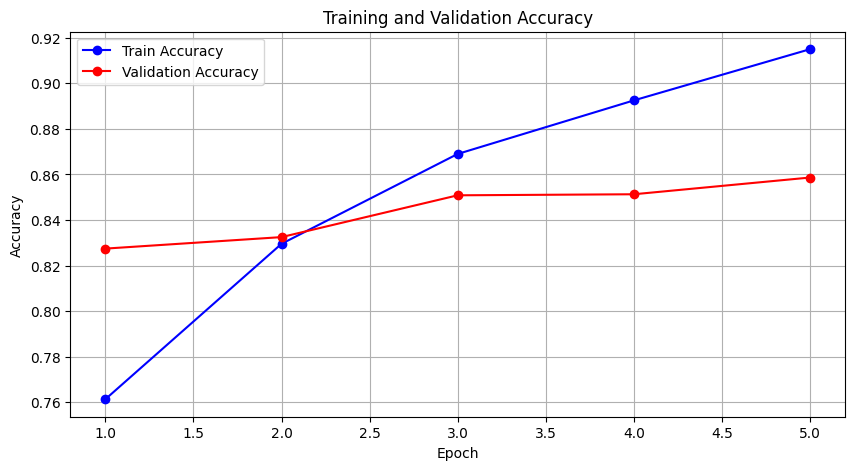

Model saved to /content/drive/MyDrive/ML3_FP//models/model_finetuned.pth


In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define CustomDataset
class CustomDataset(Dataset):
    def __init__(self, inputs, labels, label_lengths):
        self.inputs = inputs
        self.labels = labels
        self.label_lengths = label_lengths

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_values': self.inputs[idx],
            'labels': self.labels[idx],
            'label_lengths': self.label_lengths[idx]
        }

# Define accuracy computation function
def compute_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

# Training function
def train(model, data_loader, optimizer, device, accuracy_history):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(data_loader, desc="Training"):
        # Move data to the same device as the model
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_values=input_values)  # Assumes model returns logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute accuracy
        accuracy = compute_accuracy(outputs, labels)
        correct_predictions += (torch.max(outputs, 1)[1] == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / total_samples
    accuracy_history.append(avg_accuracy)
    print(f"Training Loss: {avg_loss}, Accuracy: {avg_accuracy}")

# Evaluation function
def evaluate(model, data_loader, device, accuracy_history):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Move data to the same device as the model
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_values=input_values)  # Assumes model returns logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            # Compute accuracy
            accuracy = compute_accuracy(outputs, labels)
            correct_predictions += (torch.max(outputs, 1)[1] == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / total_samples
    accuracy_history.append(avg_accuracy)
    print(f"Evaluation Loss: {avg_loss}, Accuracy: {avg_accuracy}")

# Example feature extraction (replace with actual feature extraction code)
train_inputs = feature_extractor(
    train_data, sampling_rate=16000, max_length=max_length,
    return_tensors='pt', padding=True, truncation=True
)
test_inputs = feature_extractor(
    test_data, sampling_rate=16000, max_length=max_length,
    return_tensors='pt', padding=True, truncation=True
)

# Convert feature extraction outputs to tensors and move to device
train_inputs = torch.tensor(train_inputs['input_values'], dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)
train_label_lengths = torch.tensor([1 for _ in train_labels], dtype=torch.long).to(device)

test_inputs = torch.tensor(test_inputs['input_values'], dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)
test_label_lengths = torch.tensor([1 for _ in test_labels], dtype=torch.long).to(device)

# Create datasets
train_dataset = CustomDataset(train_inputs, train_labels, train_label_lengths)
eval_dataset = CustomDataset(test_inputs, test_labels, test_label_lengths)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False, num_workers=0)

# Initialize accuracy history lists
train_accuracy_history = []
eval_accuracy_history = []

epochs = 5
# Training and evaluation loop
for epoch in range(epochs):  # Number of epochs
    print(f"Epoch {epoch + 1}")
    train(model, train_loader, optimizer, device, train_accuracy_history)
    evaluate(model, eval_loader, device, eval_accuracy_history)

def plot_accuracy(train_accuracy, eval_accuracy):
    epochs = range(1, len(train_accuracy) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracy, 'bo-', label='Train Accuracy')
    plt.plot(epochs, eval_accuracy, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot accuracy
plot_accuracy(train_accuracy_history, eval_accuracy_history)

# Save the state dictionary of the model
torch.save(model.state_dict(), f'{HOME_DIR}/models/model_finetuned.pth')
print(f"Model saved to {HOME_DIR}/models/model_finetuned.pth")

In [40]:
notebook_login()

In [41]:
from huggingface_hub import HfApi

# Save the state dictionary of the model
torch.save(model.state_dict(), f'model_finetuned.pth')
print(f"Model saved to model_finetuned.pth")

api = HfApi()

# Specify the path to your .pth file
file_path = f"model_finetuned.pth"

# Upload the file
api.upload_file(
    path_or_fileobj=file_path,
    path_in_repo="model_finetuned.pth",  # This is the name it will have in the repo
    repo_id="kvilla/wav2vec-english-speech-emotion-recognition-finetuned"
)

Model saved to model_finetuned.pth


model_finetuned.pth:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kvilla/wav2vec-english-speech-emotion-recognition-finetuned/commit/711843e15b47f8dd432ac9b1bf284cbd78a7ce3b', commit_message='Upload model_finetuned.pth with huggingface_hub', commit_description='', oid='711843e15b47f8dd432ac9b1bf284cbd78a7ce3b', pr_url=None, pr_revision=None, pr_num=None)

In [44]:
# load the newly finetuned model from huggingface repo

from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="kvilla/wav2vec-english-speech-emotion-recognition-finetuned",
    filename="model_finetuned.pth"
)

# load the newly finetuned model! from local
saved_model = torch.load(HOME_DIR + 'models/model_finetuned.pth')

# Create the model with the loaded configuration
model = Wav2Vec2ForSpeechClassification(config=config)

# Load the state dictionary
model.load_state_dict(saved_model)

print("Model initialized successfully.")

model.eval()

model_finetuned.pth:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Model initialized successfully.


Wav2Vec2ForSpeechClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=Tr

In [55]:
accuracy, true_labels, predicted_labels = evaluate_model_inference(
    model, feature_extractor, padded_audio_array[:10], max_length, id2label, sample_df)
print(f"accuracy: {accuracy}")
print(f"true_labels: {true_labels}")
print(f"predicted_labels: {predicted_labels}")

Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

accuracy: 1.0
true_labels: [2, 4, 1, 4, 0, 5, 0, 3, 2, 5]
predicted_labels: [2, 4, 1, 4, 0, 5, 0, 3, 2, 5]


In [49]:
audio = librosa.load(HOME_DIR + 'Test Sounds/test_anger.mp3', sr=16000)
predict(model, feature_extractor, audio[0], max_length, id2label)

'fear'